<a href="https://colab.research.google.com/github/MesquitaALucas/Todos-advanced/blob/main/TP2_ICV_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/amandaxm/icv-reconhecimento-captcha

fatal: destination path 'icv-reconhecimento-captcha' already exists and is not an empty directory.


In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd

# CNN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical

# MNIST
from keras.datasets import mnist

# plot
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import svm

from skimage.feature import hog

from sklearn.metrics import classification_report,accuracy_score

np.random.seed(123)  # for reproducibility

In [ ]:
path_labels = 'icv-reconhecimento-captcha/labels10k/'
path_train = 'icv-reconhecimento-captcha/treinamento/'
path_validation = 'icv-reconhecimento-captcha/validacao/'
path_test = 'icv-reconhecimento-captcha/teste/'

In [ ]:
def get_images(path):
  images = dict()
  for filename in os.listdir(path):
    images[filename.split('.')[0]] = Image.open(path + '/' + filename)
  return images

In [ ]:
images_train = get_images(path_train)
images_validation = get_images(path_validation)
images_test = get_images(path_test)

In [ ]:
labels = dict()
for filename in os.listdir(path_labels):
  with open(path_labels + '/' + filename) as f: label = f.read().replace('\n', '')
  labels[filename.split('.')[0]] = label

In [ ]:
df_train = pd.DataFrame(images_train.items(), columns=['File', 'Image'])

In [ ]:
df_validation = pd.DataFrame(images_validation.items(), columns=['File', 'Image'])

In [ ]:
df_test = pd.DataFrame(images_test.items(), columns=['File', 'Image'])

In [ ]:
df_dict = {
    'train': df_train,
    'validation': df_validation,
    'test': df_test,
}

In [ ]:
df = pd.concat([df.assign(Subset=k) for k,df in df_dict.items()]).sort_values('File')

In [ ]:
df

,File,Image,Subset
3083,000001,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train
5511,000002,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train
2280,000003,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train
1551,000004,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train
3975,000005,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train
...,...,...,...
346,009996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test
252,009997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test
453,009998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test
677,009999,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test


In [ ]:
df_labels = pd.DataFrame(labels.items(), columns=['File', 'Label'])

In [ ]:
df_labels

,File,Label
0,002013,OR1SAB
1,004990,GF72RS
2,008706,5JD5P6
3,004050,XAM3HU
4,008265,JWBESB
...,...,...
9995,000354,6PE4W2
9996,005794,3LE16T
9997,005351,WR61KV
9998,006712,T6NGW4


In [ ]:
df = pd.merge(df, df_labels, on='File')

In [ ]:
df

,File,Image,Subset,Label
0,000001,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,RNINIC
1,000002,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,TVCFS8
2,000003,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,N1O1EH
3,000004,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,OQZSL4
4,000005,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,GST2YA
...,...,...,...,...
9995,009996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test,66ZDPA
9996,009997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test,2044B3
9997,009998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test,SNB9SO
9998,009999,<PIL.JpegImagePlugin.JpegImageFile image mode=...,test,0DTW1D


In [ ]:
not_len_6_df = df[df['Label'].str.len() != 6]

In [ ]:
contains_question_df = df[df['Label'].str.contains('\?') == True]

In [ ]:
not_len_6_df['Subset'].value_counts()

,count
Subset,
train,3
validation,1
test,1


In [ ]:
contains_question_df['Subset'].value_counts()

,count
Subset,
train,98


In [ ]:
df = df[df['Label'].str.contains('\?') == False]
df = df[df['Label'].str.len() == 6]

In [ ]:
df['Image_array_1'] = df['Image'].apply(lambda image: (np.asarray(image) > 128).astype(int)[:, 12:, 0])
df['Image_array_2'] = df['Image_array_3'] = df['Image_array_4'] = df['Image_array_5'] = df['Image_array_6'] = df['Image_array_1']

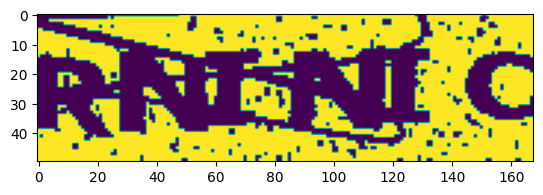

In [ ]:
plt.imshow(df['Image_array_1'][0])

In [ ]:
for i in range(6):
  df[f'Image_array_{i+1}'] = df[f'Image_array_{i+1}'].apply(lambda array: array[:, 28*i:28*i+28])

In [ ]:
labels_to_int = dict()

In [ ]:
for i in range(10):
  labels_to_int[str(i)] = i

for i in range(26):
  labels_to_int[chr(ord('A') + i)] = 10 + i

In [ ]:
df['Label_int_1'] = df['Label'].apply(lambda label: [*label]).apply(lambda l: np.array(list(map(labels_to_int.get, l))))
df['Label_int_2'] = df['Label_int_3'] = df['Label_int_4'] = df['Label_int_5'] = df['Label_int_6'] = df['Label_int_1']

In [ ]:
for i in range(6):
  df[f'Label_int_{i+1}'] = df[f'Label_int_{i+1}'].apply(lambda l: l[i])

In [ ]:
df.head()

,File,Image,Subset,Label,Image_array_1,Image_array_2,Image_array_3,Image_array_4,Image_array_5,Image_array_6,Label_int_1,Label_int_2,Label_int_3,Label_int_4,Label_int_5,Label_int_6
0,000001,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,RNINIC,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,...",27,23,18,23,18,12
1,000002,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,TVCFS8,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",29,31,12,15,28,8
2,000003,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,N1O1EH,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",23,1,24,1,14,17
3,000004,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,OQZSL4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",24,26,35,28,21,4
4,000005,<PIL.JpegImagePlugin.JpegImageFile image mode=...,train,GST2YA,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",16,28,29,2,34,10


In [ ]:
X_train =       np.array([np.array(list(df[df['Subset'] == 'train'][f'Image_array_{i+1}'])) for i in range(6)])
X_test =        np.array([np.array(list(df[df['Subset'] == 'test'][f'Image_array_{i+1}'])) for i in range(6)])
X_validation =  np.array([np.array(list(df[df['Subset'] == 'validation'][f'Image_array_{i+1}'])) for i in range(6)])
Y_train =       np.array([np.array(list(df[df['Subset'] == 'train'][f'Label_int_{i+1}'])) for i in range(6)])
Y_test =        np.array([np.array(list(df[df['Subset'] == 'test'][f'Label_int_{i+1}'])) for i in range(6)])
Y_validation =  np.array([np.array(list(df[df['Subset'] == 'validation'][f'Label_int_{i+1}'])) for i in range(6)])

In [ ]:
X_train_left = X_train[0]
X_train_center = X_train[1:-1]
X_train_right = X_train[-1]

X_test_left = X_test[0]
X_test_center = X_test[1:-1]
X_test_right = X_test[-1]

X_validation_left = X_validation[0]
X_validation_center = X_validation[1:-1]
X_validation_right = X_validation[-1]

Y_train_left = Y_train[0]
Y_train_center = Y_train[1:-1]
Y_train_right = Y_train[-1]

Y_test_left = Y_test[0]
Y_test_center = Y_test[1:-1]
Y_test_right = Y_test[-1]

Y_validation_left = Y_validation[0]
Y_validation_center = Y_validation[1:-1]
Y_validation_right = Y_validation[-1]

In [ ]:
a, b, c, d = X_train_center.shape
X_train_center = X_train_center.reshape((a*b, c, d))
a, b, c, d = X_test_center.shape
X_test_center = X_test_center.reshape((a*b, c, d))
a, b, c, d = X_validation_center.shape
X_validation_center = X_validation_center.reshape((a*b, c, d))
a, b = Y_train_center.shape
Y_train_center = Y_train_center.reshape((a*b))
a, b = Y_test_center.shape
Y_test_center = Y_test_center.reshape((a*b))
a, b = Y_validation_center.shape
Y_validation_center = Y_validation_center.reshape((a*b))

In [ ]:
category_count = len(labels_to_int)

Y_train_left_categorical = to_categorical(Y_train_left, category_count)
Y_train_center_categorical = to_categorical(Y_train_center, category_count)
Y_train_right_categorical = to_categorical(Y_train_right, category_count)

Y_test_left_categorical = to_categorical(Y_test_left, category_count)
Y_test_center_categorical = to_categorical(Y_test_center, category_count)
Y_test_right_categorical = to_categorical(Y_test_right, category_count)

Y_validation_left_categorical = to_categorical(Y_validation_left, category_count)
Y_validation_center_categorical = to_categorical(Y_validation_center, category_count)
Y_validation_right_categorical = to_categorical(Y_validation_right, category_count)

# Convolucional

## Left

In [ ]:
# Sequential layer
model = Sequential()

In [ ]:
# CNN input layer
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(50,28,1)))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# hiden layers
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))

In [ ]:
# fully connected layer
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(category_count, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 50, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 50, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 25, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 25, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 11200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │         358,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 36)                  │           1,188 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 369,188 (1.41 MB)

 Trainable params: 369,188 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
response = model.fit(X_train_left, Y_train_left_categorical,
          batch_size=128, epochs=5, verbose=1)

Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 29s 450ms/step - accuracy: 0.0488 - loss: 3.5020
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 432ms/step - accuracy: 0.1288 - loss: 3.0675
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 431ms/step - accuracy: 0.1921 - loss: 2.7096
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 448ms/step - accuracy: 0.2286 - loss: 2.4827
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 39s 420ms/step - accuracy: 0.2558 - loss: 2.3693


In [ ]:
score = model.evaluate(X_test_left, Y_test_left_categorical, verbose=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7492 - loss: 1.4617


In [ ]:
score = model.evaluate(X_validation_left, Y_validation_left_categorical, verbose=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7465 - loss: 1.4241


In [ ]:
print(score)

[1.4105511903762817, 0.7527527809143066]


## Center

In [ ]:
# Sequential layer
model = Sequential()

In [ ]:
# CNN input layer
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(50,28,1)))

In [ ]:
# hiden layers
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))

In [ ]:
# fully connected layer
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(category_count, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 50, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 50, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 25, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 25, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 11200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │         358,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 36)                  │           1,188 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 369,188 (1.41 MB)

 Trainable params: 369,188 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
response = model.fit(X_train_center, Y_train_center_categorical,
          batch_size=128, epochs=5, verbose=1)

Epoch 1/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 107s 426ms/step - accuracy: 0.0780 - loss: 3.3660
Epoch 2/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 142s 424ms/step - accuracy: 0.2363 - loss: 2.4862
Epoch 3/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 101s 411ms/step - accuracy: 0.3148 - loss: 2.1060
Epoch 4/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 106s 430ms/step - accuracy: 0.3595 - loss: 1.9327
Epoch 5/5
247/247 ━━━━━━━━━━━━━━━━━━━━ 138s 415ms/step - accuracy: 0.3739 - loss: 1.8629


In [ ]:
score = model.evaluate(X_test_center, Y_test_center_categorical, verbose=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8055 - loss: 0.8040


In [ ]:
score = model.evaluate(X_validation_center, Y_validation_center_categorical, verbose=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8228 - loss: 0.7829


In [ ]:
print(score)

[0.8226786255836487, 0.7987987995147705]


## Right

In [ ]:
# Sequential layer
model = Sequential()

In [ ]:
# CNN input layer
model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(50,28,1)))

In [ ]:
# hiden layers
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))

In [ ]:
# fully connected layer
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(category_count, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 50, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 50, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 25, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 25, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 11200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │         358,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 36)                  │           1,188 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 369,188 (1.41 MB)

 Trainable params: 369,188 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
response = model.fit(X_train_right, Y_train_right_categorical,
          batch_size=128, epochs=5, verbose=1)

Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 437ms/step - accuracy: 0.0424 - loss: 3.5204
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 413ms/step - accuracy: 0.1470 - loss: 2.9426
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 416ms/step - accuracy: 0.2473 - loss: 2.4170
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 43s 454ms/step - accuracy: 0.3083 - loss: 2.1799
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 38s 411ms/step - accuracy: 0.3567 - loss: 1.9983


In [ ]:
score = model.evaluate(X_test_right, Y_test_right_categorical, verbose=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7812 - loss: 0.9721


In [ ]:
print(score)

[0.9892748594284058, 0.7767767906188965]


# HOG

In [ ]:
for i in range(6):
  i = i + 1
  fds = list()
  hog_images = list()
  for image in df[f'Image_array_{i}']:
    fd, hog_image = hog(
      image,
      orientations=8,
      pixels_per_cell=(10, 10),
      cells_per_block=(1, 1),
      visualize=True,
    )
    fds.append(fd)
    hog_images.append(hog_image)
  df[f'fd_{i}'] = fds
  df[f'hog_image_{i}'] = hog_images

In [ ]:
fd_train =       np.array([np.array(list(df[df['Subset'] == 'train'][f'fd_{i+1}'])) for i in range(6)])
fd_test =        np.array([np.array(list(df[df['Subset'] == 'test'][f'fd_{i+1}'])) for i in range(6)])
fd_validation =  np.array([np.array(list(df[df['Subset'] == 'validation'][f'fd_{i+1}'])) for i in range(6)])

In [ ]:
fd_train_left = fd_train[0]
fd_test_left = fd_test[0]
fd_validation_left = fd_validation[0]

In [ ]:
clf = svm.SVC()

In [ ]:
clf.fit(fd_train_left, Y_train_left)

SVC()

In [ ]:
Y_pred_left = clf.predict(fd_test_left)

In [ ]:
print("Accuracy: "+str(accuracy_score(Y_test_left, Y_pred_left)))
print('\n')
print(classification_report(Y_test_left, Y_pred_left))

Accuracy: 0.3913913913913914


              precision    recall  f1-score   support

           0       0.38      0.38      0.38        34
           1       0.41      0.35      0.38        20
           2       0.35      0.54      0.42        28
           3       0.50      0.37      0.42        30
           4       0.60      0.70      0.65        30
           5       0.48      0.43      0.45        28
           6       0.27      0.42      0.33        24
           7       0.33      0.44      0.38        27
           8       0.34      0.73      0.46        26
           9       0.30      0.50      0.37        24
          10       0.44      0.70      0.54        23
          11       0.17      0.25      0.20        20
          12       0.18      0.12      0.15        33
          13       0.50      0.12      0.19        34
          14       0.67      0.28      0.39        29
          15       0.43      0.16      0.23        19
          16       0.26      0.22      0.24       